# LOESS Trend Analysis

In [1]:
from pathlib import Path
from functools import cache

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mgplot as mg
from statsmodels.nonparametric.smoothers_lowess import lowess  # type: ignore[import-untyped]
from IPython.display import display

from common import RFOOTER

LFOOTER = "Australia. Polling data sourced from Wikipedia. "
SHOW_PLOT = True

In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/LOESS-trend/")
mg.clear_chart_dir()

## Upload the data

In [3]:
def load_polling_data(data_type: str = "voting_intention") -> pd.DataFrame:
    """Load the most recent polling data with data freshness validation.
    
    Args:
        data_type: Either "voting_intention" or "preferred_pm"
    """
    today = pd.Timestamp.now().strftime("%Y-%m-%d")
    data_dir = Path("../poll-data")

    # Set file prefix based on data type
    file_prefix = data_type

    # Look for today's file first
    today_file = data_dir / f"{file_prefix}_next_{today}.csv"
    fallback_file = data_dir / f"{file_prefix}_next.csv"

    if today_file.exists():
        data_path = today_file
        print(f"Using today's {data_type} data file: {data_path}")
    else:
        # Look for any recent file with date suffix
        pattern = f"{file_prefix}_next_*.csv"
        recent_files = list(data_dir.glob(pattern))

        help_msg = "Consider running the scraper first: automated/scrape_wikipedia_polls.py"
        if recent_files:
            # Sort by filename (date suffix) and take most recent
            most_recent = sorted(recent_files)[-1]
            file_date = most_recent.stem.split("_")[-1]  # Extract date from filename

            print(f"⚠️  WARNING: No {data_type} data file found for today ({today})")
            print(f"Using most recent file: {most_recent} (from {file_date})")
            print(help_msg)
            data_path = most_recent
        elif fallback_file.exists():
            print(f"⚠️  WARNING: No dated {data_type} files found")
            print(f"Using fallback file: {fallback_file}")
            print(help_msg)
            data_path = fallback_file
        else:
            print(f"No {data_type} data files found. Please run the scraper first.")
            return pd.DataFrame()

    # Load the data
    df = pd.read_csv(data_path)
    if "parsed_date" in df.columns:
        df.index = pd.PeriodIndex(df["parsed_date"], freq="D")

    df = df.dropna(axis=1, how="all")  # drop all NAN columns

    return df


# Load voting intention data
data = load_polling_data("voting_intention")

Using today's voting_intention data file: ../poll-data/voting_intention_next_2025-12-16.csv


### Data Preview

In [4]:
def preview_polling_data(data: pd.DataFrame) -> None:
    """Display a preview of the polling data."""
    display(data.head(10))
    print(data.columns)


# Show the data preview
preview_polling_data(data)

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,2PP vote ALP,2PP vote L/NP,parsed_date,problematic
parsed_date,,,,,,,,,,,,,,
NaT,Date,Firm,Interview mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-12-09,7 – 12 Dec 2025,Redbridge,Online,1012.0,35.000000,26.000000,13.000000,17.000000,NaN,9.000000,56.0,44.0,2025-12-09,False
2025-12-05,3 – 8 Dec 2025,Essential,Online,1300.0,35.789474,27.368421,10.526316,17.894737,NaN,8.421053,52.1,47.9,2025-12-05,False
2025-12-04,2 – 7 Dec 2025,Resolve,Telephone/Online,1800.0,35.000000,26.000000,11.000000,14.000000,8.0,6.000000,55.0,45.0,2025-12-04,False
2025-11-16,7 – 26 Nov 2025,Redbridge,Online,4775.0,35.000000,26.000000,10.000000,18.000000,NaN,11.000000,54.0,46.0,2025-11-16,False
2025-11-21,19 – 24 Nov 2025,Essential,Online,1020.0,38.250000,28.687500,11.687500,15.937500,NaN,7.437500,53.2,46.8,2025-11-21,True
2025-11-18,17 – 20 Nov 2025,Newspoll,Online,1245.0,36.000000,24.000000,13.000000,15.000000,NaN,12.000000,58.0,42.0,2025-11-18,False
2025-11-14,12 – 17 Nov 2025,YouGov (MRP),Online,3530.0,34.000000,26.000000,12.000000,18.000000,5.0,5.000000,54.8,45.2,2025-11-14,False
2025-11-10,4 – 17 Nov 2025,Spectre Strategy,Online,1007.0,33.000000,25.000000,12.500000,17.500000,NaN,12.000000,53.0,47.0,2025-11-10,False


Index(['Date', 'Brand', 'Interview mode', 'Sample size', 'Primary vote ALP',
       'Primary vote L/NP', 'Primary vote GRN', 'Primary vote ONP',
       'Primary vote IND', 'Primary vote OTH', '2PP vote ALP', '2PP vote L/NP',
       'parsed_date', 'problematic'],
      dtype='object')


### Any problematic?

In [5]:
# Check for any problematic entries as identified by the scraper
data.loc[data.problematic]

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,2PP vote ALP,2PP vote L/NP,parsed_date,problematic
parsed_date,,,,,,,,,,,,,,
NaT,Date,Firm,Interview mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-11-21,19 – 24 Nov 2025,Essential,Online,1020.0,38.25,28.6875,11.6875,15.9375,NaN,7.4375,53.2,46.8,2025-11-21,True
2025-07-24,18 – 30 Jul 2025,Wolf & Smith,Online,5000.0,36.00,30.0000,NaN,NaN,NaN,NaN,57.0,43.0,2025-07-24,True
NaT,Date,Firm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2025-11-14,12 – 17 Nov 2025,YouGov (MRP),NaN,3783.0,40.00,30.0000,17.0000,21.0000,16.0,NaN,NaN,NaN,2025-11-14,True


## Establish 2025 Election benchmarks

In [6]:
COALITION_LIST = ["LP", "LNP", "NP", "CLP"]
OTHER_LIST = ["DLP", "DEM", "UAP", "Others"]
COALITION = "Coalition"
OTHER = "Other"

@cache
def get_last_election() -> pd.Series:
    """Retrieve the latest election results for annotations."""    

    # Capture latest value for 2025 election annotations
    election_df = pd.read_csv(
        "../historic-data/election-outcomes.csv",
        sep=' ',
        skipinitialspace=True,
        header=0,
        comment='#',
        na_values=["", "-"],
    ).fillna(0)  # make sure NA values are 0 for numeric addition

    # Convert all columns to numeric where possible
    for col in election_df.columns:
        try:
            election_df[col] = pd.to_numeric(election_df[col])
        except ValueError:
            continue

    # only keep numeric columns and filter for 2025 election results
    df_numeric = election_df.select_dtypes(include=['number'])
    election_2025 = df_numeric[df_numeric["Year"] == 2025].iloc[0]

    # Calculate Coalition and Others totals
    election_2025[COALITION] = election_2025[COALITION_LIST].sum()
    election_2025[OTHER] = election_2025[OTHER_LIST].sum()

    # Clean up to keep only relevant fields
    election_2025.drop(labels=["Year"]+COALITION_LIST+OTHER_LIST, inplace=True)

    return election_2025


e25 = get_last_election()
print("2025 Election results for annotation:\n", e25)
print("Primary vote check (should be 100%): ",
      e25[COALITION] + e25["ALP"] + e25["GRN"] + e25["ON"] + e25[OTHER])

2025 Election results for annotation:
 ALP          34.56
GRN          12.20
ON            6.40
Labor2pp     55.22
Coalition    31.82
Other        15.02
Name: 30, dtype: float64
Primary vote check (should be 100%):  100.0


## LOESS Smoothing

In [7]:
def create_loess_smoothing(data: pd.DataFrame, column: str, day_span=90) -> pd.Series:
    """Create LOESS smoothing and return smoothed data."""
    # Sort by index (PeriodIndex) instead of 'date' column to avoid ambiguity
    df_2pp_sorted = data.sort_index().copy()

    # Apply LOESS smoothing
    series = df_2pp_sorted[column].dropna()
    dates_as_ordinals = [p.ordinal for p in series.index]
    denominator = np.max(dates_as_ordinals) - np.min(dates_as_ordinals)
    fraction = day_span / denominator if denominator else 1
    fraction = fraction if fraction < 1 else 1
    smoothed = lowess(
        df_2pp_sorted[column].dropna(),
        dates_as_ordinals,
        frac=fraction,  # Smoothing parameter - adjust as needed
    )
    smoothed_series = pd.Series(smoothed[:, 1], index=series.index)
    smoothed_series.name = f"LOESS {day_span}-day smoothing"
    smoothed_series = smoothed_series[~smoothed_series.index.duplicated(keep="first")]

    return smoothed_series

In [8]:
def plot_scatter_on_ax(
    ax: plt.Axes,
    df: pd.DataFrame,
    col: str,
    color: str,
    symbols: list[str],
) -> None:
    """Plot scatter points for a single series on given axes."""
    for i, brand in enumerate(sorted(df["Brand"].unique())):
        selection = df[df["Brand"] == brand][col]
        if selection.empty or selection.isna().all():
            continue
        # Use ordinals to match mgplot's internal representation
        x = [p.ordinal for p in selection.index]
        ax.scatter(
            x,
            selection.to_numpy(),
            color=color,
            s=20,
            marker=symbols[i % len(symbols)],
            alpha=0.5,
        )


def create_chart_with_loess(
    df: pd.DataFrame,
    series: str | list[dict],
    name: str,
    color: str = "",
    f: str = "",
) -> None:
    """Create and display the LOESS chart with polling data.
    
    Args:
        df: DataFrame with polling data
        series: Either a column name (str) for single series, or a list of dicts
                [{"col": "...", "color": "...", "label": "...", "lw": ...}, ...] for multiple series
        name: Chart title
        color: Color for single series mode (ignored if series is a list)
        f: Additional footer text
    """
    symbols = list("os^v<>Dx1234+*pHh")
    total_polls = 0

    if isinstance(series, str):
        # Single series mode - use mg.line_plot_finalise directly
        col = series
        smoothed = create_loess_smoothing(df, col)
        
        _fig, ax = plt.subplots()
        plot_scatter_on_ax(ax, df, col, color, symbols)
        
        # Add 2025 election reference line if available
        prev_election = get_last_election()
        results_map = {
            "2PP vote ALP": prev_election["Labor2pp"],
            "2PP vote L/NP": 100 - prev_election["Labor2pp"],
            "Primary vote ALP": prev_election["ALP"],
            "Primary vote L/NP": prev_election[COALITION],
            "Primary vote GRN": prev_election["GRN"],
            "Primary vote ONP": prev_election["ON"],
            "Others Primary Vote": prev_election[OTHER],
        }
        if col in results_map:
            result = results_map[col]
            ax.axhline(y=result, color=color, linestyle="--", alpha=0.6, linewidth=2.0,
                    label=f"2025 Result: {result:.1f}%")
        
        total_polls = len(df[col].dropna())
        mg.line_plot_finalise(
            smoothed,
            ax=ax,
            title=f"{name} - Trend",
            xlabel=None,
            ylabel="Percent (%)",
            color=color,
            width=2.5,
            legend={"loc": "best", "fontsize": "small"},
            rfooter=RFOOTER,
            lfooter=f"{LFOOTER} {f} n={total_polls} polls. ".replace("  ", " "),
            show=SHOW_PLOT,
        )
    else:
        # Multiple series mode - build DataFrame of smoothed series
        smoothed_df = pd.DataFrame()
        colors = []
        widths = []
        
        _fig, ax = plt.subplots()
        for s in series:
            col = s["col"]
            plot_scatter_on_ax(ax, df, col, s["color"], symbols)
            smoothed = create_loess_smoothing(df, col)
            smoothed_df[s["label"]] = smoothed
            colors.append(s["color"])
            widths.append(s.get("lw", 2.5))
            total_polls += len(df[col].dropna())
        
        mg.line_plot_finalise(
            smoothed_df,
            ax=ax,
            title=f"{name} - Trend",
            xlabel=None,
            ylabel="Percent (%)",
            color=colors,
            width=widths,
            legend={"loc": "best", "fontsize": "small"},
            rfooter=RFOOTER,
            lfooter=f"{LFOOTER} {f} n={total_polls} polls. ".replace("  ", " "),
            show=SHOW_PLOT,
        )

## Plot LOESS election charts

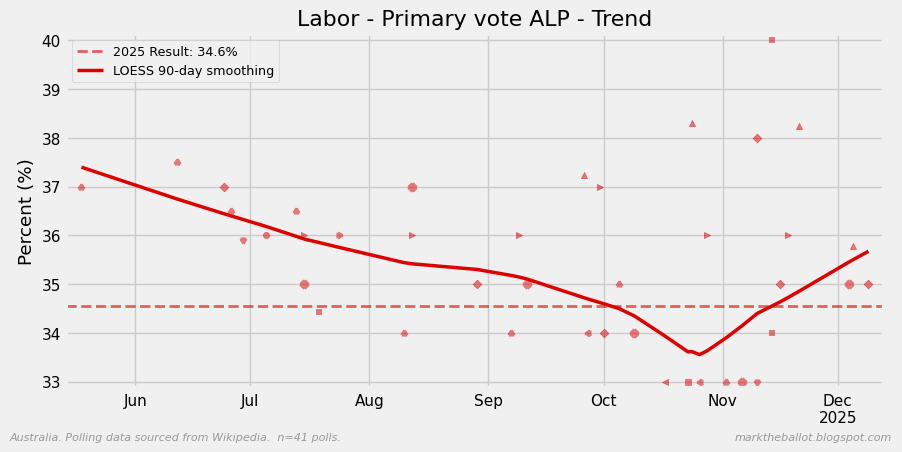

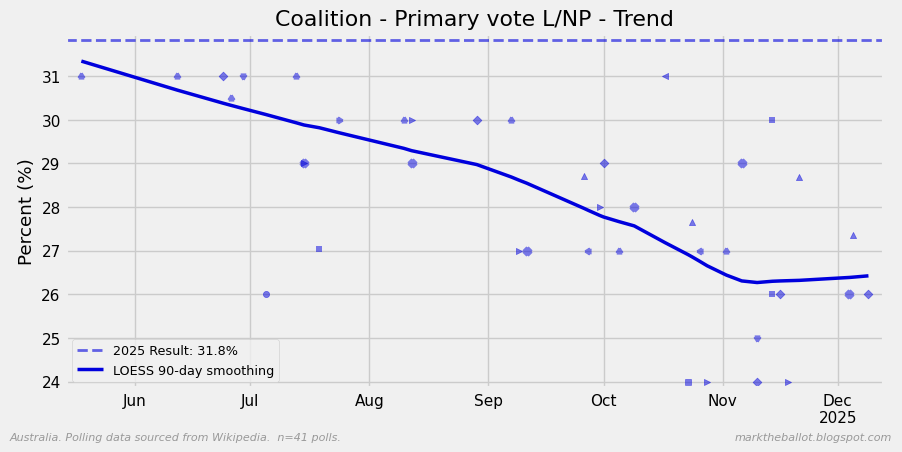

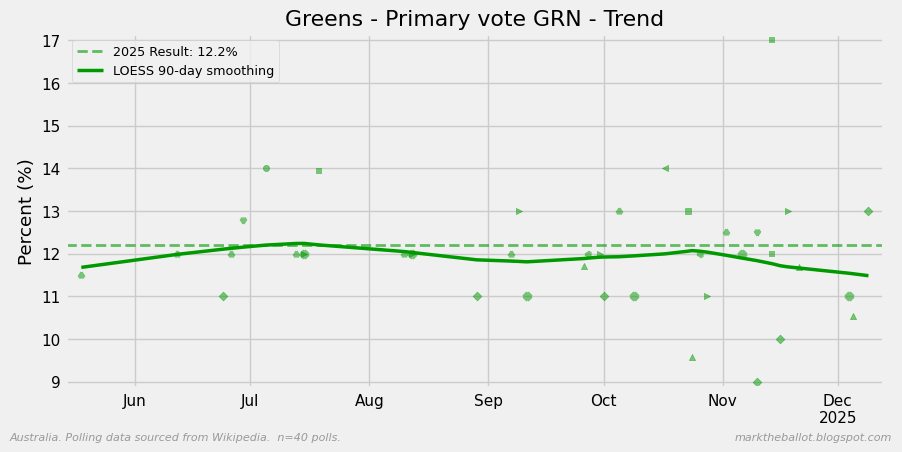

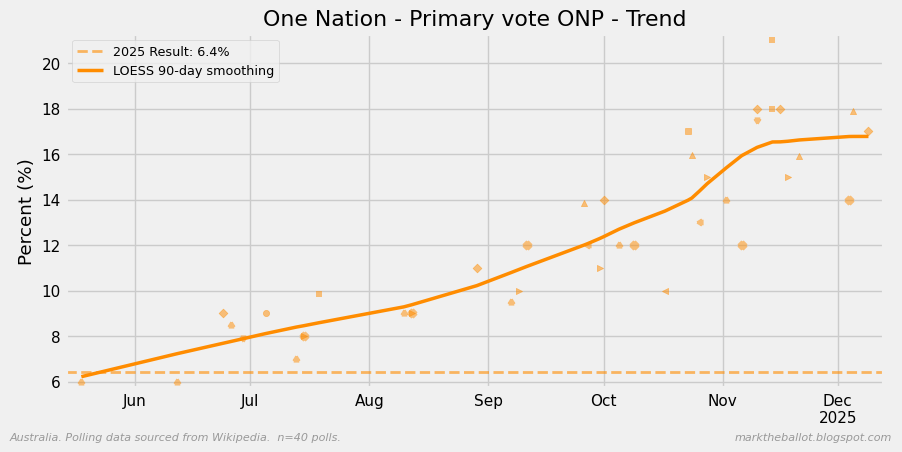

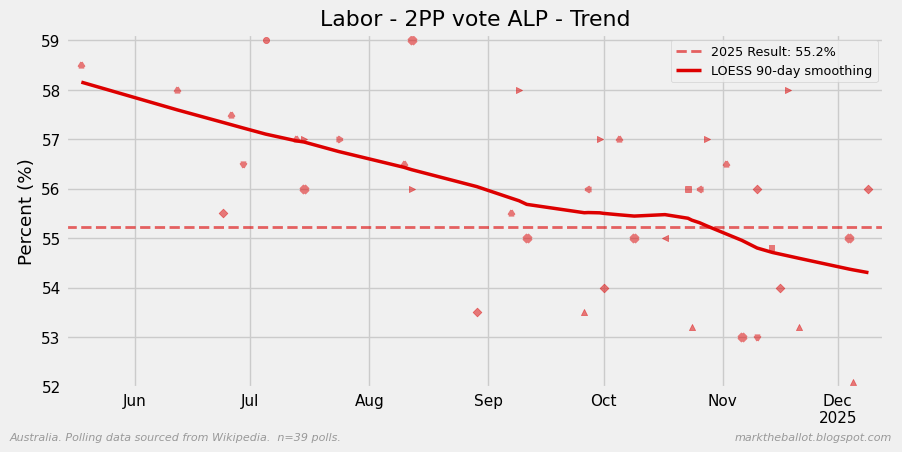

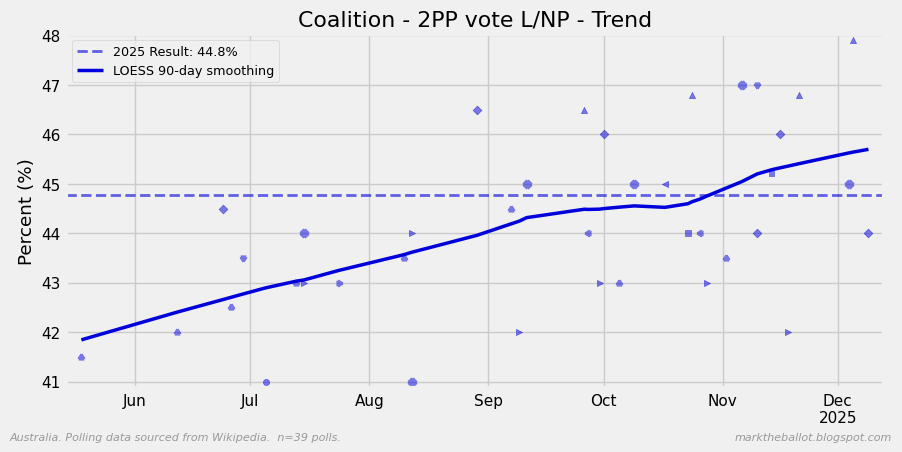

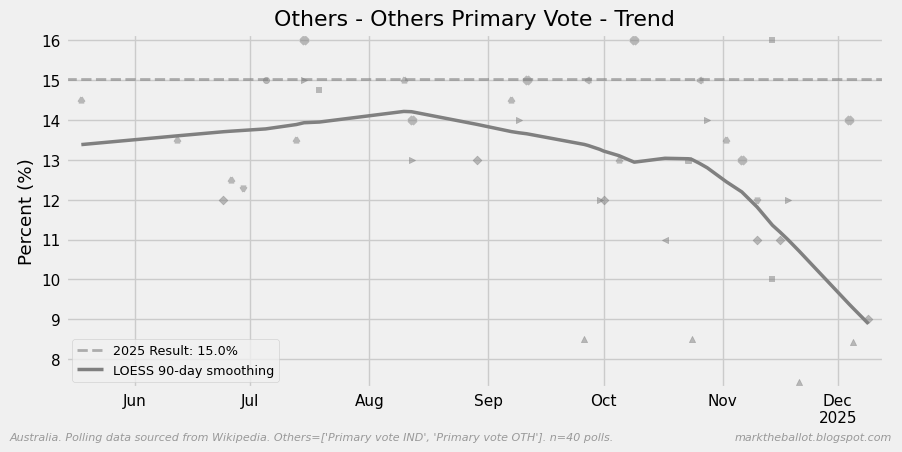

In [9]:
def plot_loess():
    """Plot LOESS trends for specified parties and others."""

    wanted = {
        # party: [name, color]
        "ALP": ["Labor", "#dd0000"],
        "L/NP": ["Coalition", "#0000dd"],
        "GRN": ["Greens", "#009900"],
        "ONP": ["One Nation", "darkorange"],
    }
    used = []
    for col in data.columns:
        if "vote" not in col:
            continue
        for w in wanted:
            if w in col:
                used.append(col)
                name, color = wanted[w]
                create_chart_with_loess(
                    data,
                    series=col,
                    name=f"{name} - {col}",
                    color=color,
                )

    # Create chart for "Others Primary Vote"
    remaining = [w for w in data.columns if w not in used and "vote" in w]
    col = "Others Primary Vote"
    data[col] = data[remaining].sum(axis=1, skipna=True)
    problematic = data[remaining].isna().all(axis=1)
    data.loc[problematic, col] = np.nan  # Ensure problematic rows are NaN
    create_chart_with_loess(
        data,
        series=col,
        name=f"Others - {col}",
        color="grey",
        f=f"Others={remaining}. ",
    )


plot_loess()

## Attitudinal Polling (Preferred PM)

In [10]:
# Load attitudinal (preferred PM) data
attitudinal_data = load_polling_data("preferred_pm")

⚠️  WARNING: No preferred_pm data file found for today (2025-12-16)
Using most recent file: ../poll-data/preferred_pm_next_2025-12-07.csv (from 2025-12-07)
Consider running the scraper first: automated/scrape_wikipedia_polls.py


In [11]:
# Preview attitudinal polling data
if not attitudinal_data.empty:
    display(attitudinal_data.head(10))
    print("Columns:", attitudinal_data.columns.tolist())
else:
    print("No attitudinal polling data available")

,Date,Brand,Sample size,Preferred prime minister Albanese,Preferred prime minister Ley,Preferred prime minister Don't know,Preferred prime minister Net,Albanese Satisfied,Albanese Dissatisfied,Albanese Don't know,Albanese Net,Ley Satisfied,Ley Dissatisfied,Ley Don't know,Ley Net,parsed_date
parsed_date,,,,,,,,,,,,,,,,
2025-11-21,19 – 24 Nov 2025,Essential,1020,NaN,NaN,NaN,NaN,47.0,43.0,10.0,4.0,31.0,44.0,25.0,-19.0,2025-11-21
2025-11-18,17 – 20 Nov 2025,Newpoll,1245,54.000000,27.000000,19.000000,27.0,47.0,47.0,6.0,0.0,26.0,55.0,19.0,-29.0,2025-11-18
2025-11-10,7 – 13 Nov 2025,Redbridge,1011,63.492063,15.873016,20.634921,30.0,37.0,39.0,24.0,-2.0,13.0,34.0,53.0,-21.0,2025-11-10
2025-11-06,4 – 8 Nov 2025,Resolve,1804,39.000000,25.000000,36.000000,14.0,44.0,44.0,12.0,0.0,33.0,41.0,26.0,-8.0,2025-11-06
2025-10-28,27 – 30 Oct 2025,Newspoll,1265,54.000000,27.000000,19.000000,27.0,46.0,51.0,3.0,-5.0,25.0,58.0,17.0,-33.0,2025-10-28
2025-10-26,23 – 30 Oct 2025,YouGov,4578,51.000000,26.000000,23.000000,25.0,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,-22.0,2025-10-26
2025-10-24,22 – 27 Oct 2025,Essential,1041,NaN,NaN,NaN,NaN,45.0,44.0,11.0,1.0,32.0,43.0,24.0,-9.0,2025-10-24
2025-10-17,15 – 20 Oct 2025,Freshwater,1530,48.000000,31.000000,22.000000,17.0,NaN,NaN,NaN,-7.0,NaN,NaN,NaN,-5.0,2025-10-17
2025-10-09,7 – 12 Oct 2025,Resolve,1800,40.000000,23.000000,37.000000,17.0,41.0,47.0,12.0,-6.0,33.0,38.0,28.0,-5.0,2025-10-09


Columns: ['Date', 'Brand', 'Sample size', 'Preferred prime minister Albanese', 'Preferred prime minister Ley', "Preferred prime minister Don't know", 'Preferred prime minister Net', 'Albanese Satisfied', 'Albanese Dissatisfied', "Albanese Don't know", 'Albanese Net', 'Ley Satisfied', 'Ley Dissatisfied', "Ley Don't know", 'Ley Net', 'parsed_date']


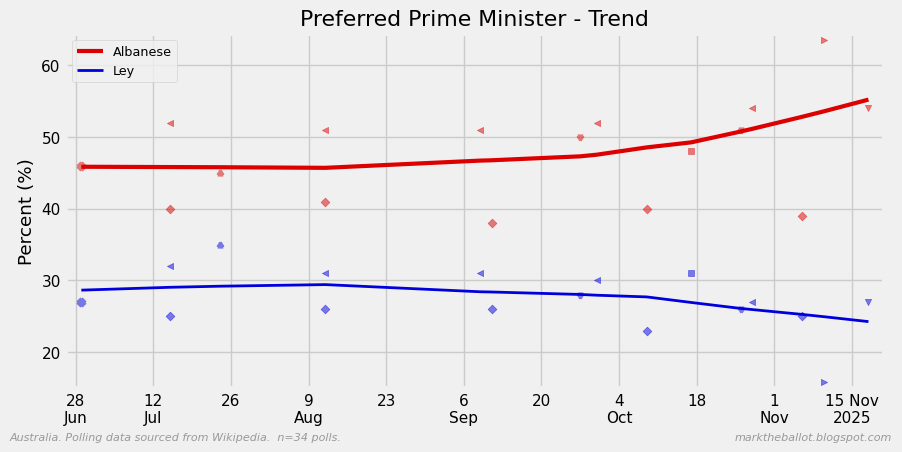

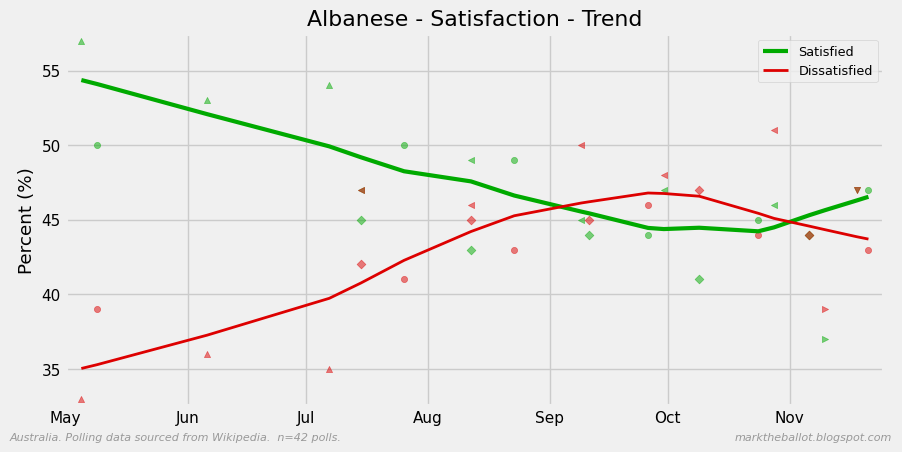

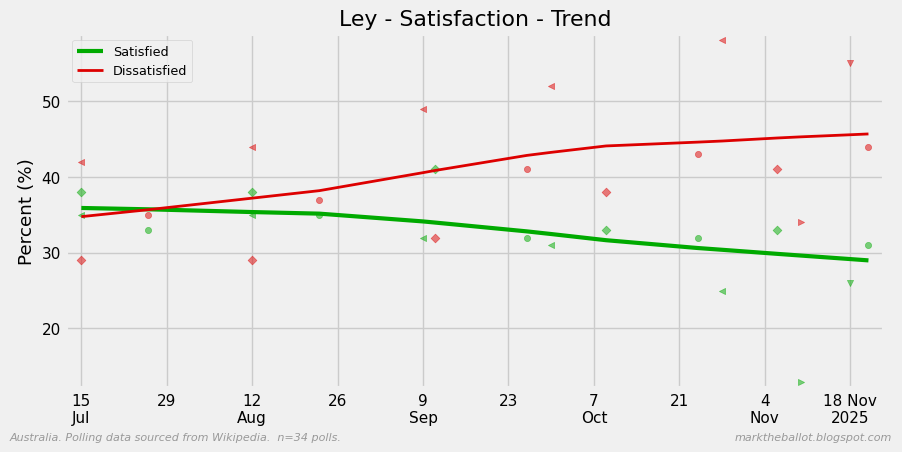

In [12]:
def plot_attitudinal_loess():
    """Plot LOESS trends for attitudinal polling data."""
    if attitudinal_data.empty:
        print("No attitudinal data to plot")
        return

    # Define grouped charts: each is a list of series to plot together
    # Using different linewidths (2 vs 3) for accessibility
    charts = [
        {
            "name": "Preferred Prime Minister",
            "series": [
                {"col": "Preferred prime minister Albanese", "color": "#dd0000", "label": "Albanese", "lw": 3},
                {"col": "Preferred prime minister Ley", "color": "#0000dd", "label": "Ley", "lw": 2},
            ],
        },
        {
            "name": "Albanese - Satisfaction",
            "series": [
                {"col": "Albanese Satisfied", "color": "#00aa00", "label": "Satisfied", "lw": 3},
                {"col": "Albanese Dissatisfied", "color": "#dd0000", "label": "Dissatisfied", "lw": 2},
            ],
        },
        {
            "name": "Ley - Satisfaction",
            "series": [
                {"col": "Ley Satisfied", "color": "#00aa00", "label": "Satisfied", "lw": 3},
                {"col": "Ley Dissatisfied", "color": "#dd0000", "label": "Dissatisfied", "lw": 2},
            ],
        },
    ]

    for chart in charts:
        # Filter to only include series with columns that exist in the data
        valid_series = [s for s in chart["series"] if s["col"] in attitudinal_data.columns]
        if not valid_series:
            print(f"No data for chart: {chart['name']}")
            continue
        
        try:
            create_chart_with_loess(
                attitudinal_data,
                series=valid_series,
                name=chart["name"],
            )
        except Exception as e:
            print(f"Could not plot {chart['name']}: {e}")


plot_attitudinal_loess()

## Finished

In [13]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-12-16 08:38:25

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas     : 2.3.3
pathlib    : 1.0.1
numpy      : 2.3.5
matplotlib : 3.10.7
IPython    : 9.8.0
statsmodels: 0.14.6
mgplot     : 0.2.14

Watermark: 2.5.0



In [14]:
print("The end.")

The end.
